# Deep Learning 
So we did a pretty good job on regression, but there's two more things I want to do.

First: Lets use position instead of 'FZ' and 'HAZ'. If we can do this, it may give us a smaller spread for the 1 to 1 plots.

Second: Lets work on a neural network and make it deep! Well, shallow, but deep. Code primarily came from:
https://colab.research.google.com/drive/1J8ZTI2UIJCwml2nrLVu8Gg0GXEz-7ZK0#scrollTo=H9QlV0BC_9PY

In [18]:
#i'm just importing everything I could possibly need here
from scipy.signal import savgol_filter
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from itertools import zip_longest
import matplotlib as mpl
import seaborn as sns
import pylab
import math
from operator import itemgetter
import re
# Import module to split dataset
from sklearn.model_selection import train_test_split
# Import module for fitting
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVR
from sklearn import linear_model
import time
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import RobustScaler #https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.isotonic import IsotonicRegression
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
#import seaborn as sns

from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
#import seaborn as sb
#import matplotlib.pyplot as plt
#import pandas as pd
#import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

In [19]:
#lets unpickle our dataframes!
only_347H = pd.read_pickle("./only_347H.pkl")
only_740H = pd.read_pickle("./only_740H.pkl")

#Maybe we could replace composition for 347H with dummy variables instead?
only_347H.replace([0.04, 0.08], ['Low Carbon', 'High Carbon'], inplace=True)
carbon = pd.get_dummies(only_347H['Composition'], drop_first=True)
only_347H = pd.concat([only_347H, carbon], axis=1)
only_347H.drop(['Composition'], axis=1, inplace=True)
#print (only_740H.head)

# Split data into 'X' features and 'y' target label sets
X = only_740H[['Strain', 'Temperature', 'Time', 'Position']]
y = only_740H['Average']
Z = only_347H[['Strain', 'Temperature', 'Time', 'Position', 'Low Carbon']]
i = only_347H['Average']

# Shorter code than before
We're just going to be looking at Kernal Ridge (for comparison), Decision Tree, Random Forest, and K Neighbors since they outperformed all the other models last time.

In [20]:
#we created a list of all the models and created the param_grid for use in GridSearchCV

models = {'Kernal Ridge':KernelRidge(),                     #https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html
          'Decision Tree': DecisionTreeRegressor(),         #https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
          'Random Forest': RandomForestRegressor(),         #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
          'K Neighbors': KNeighborsRegressor(),             #https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html
          #'Elastic Net': ElasticNet(),                      #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet
          #'RANSAC': RANSACRegressor(),                      #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html#sklearn.linear_model.RANSACRegressor
          #'Theil Sen': TheilSenRegressor(),                 #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TheilSenRegressor.html#sklearn.linear_model.TheilSenRegressor
          #'Huber': HuberRegressor(),                        #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.HuberRegressor.html#sklearn.linear_model.HuberRegressor
          #'SGD': SGDRegressor(),                            #https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html#sklearn.linear_model.SGDRegressor
          #'Gradient Boosting': GradientBoostingRegressor(), #https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor
          #'Gaussian Process': GaussianProcessRegressor(), #results were all over the place #https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html#sklearn.gaussian_process.GaussianProcessRegressor
          #'PLS' : PLSRegression(),                          #https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html#sklearn.cross_decomposition.PLSRegression
          #'Multi-layer Perceptron': MLPRegressor(),         #https://sc3ikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html#sklearn.neural_network.MLPRegressor
          #'Support Vector':SVR()                            #https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html
          #'Isotonic': IsotonicRegression(), #need to flatten X values, also only for all increasing or all decreasing #https://scikit-learn.org/stable/modules/generated/sklearn.isotonic.IsotonicRegression.html#sklearn.isotonic.IsotonicRegression
          #'Logistic': LogisticRegression() #doesn't work for continuous
         }

Most of this is copy paste. This is the hyperparameter optimization for the grid search CV

In [43]:
C_range = np.logspace(-2, 10, 5) #np.logspace(-2, 10, 13)
gamma_range = [10e-5, 0.001, 0.01, 0.1, 1, 100]#np.logspace(-9, 3, 8) #np.logspace(-9, 3, 13)
alpha_range = np.logspace(-7, 2, 8)
epsilon_range = np.concatenate((np.logspace(-5, 0, 3),np.arange(2,11,2))) #np.logspace(-5, 0, 8)
epsilon_range_v2 = np.logspace(-9, 0, 4) #np.logspace(-9, 0, 13)
epsilon_range_v3 = np.linspace(1.01,20,5)
max_iter_range = np.arange(100, 900, 200, dtype=int)
n_estimator_range = np.arange(100, 400, 100, dtype=int)
learning_rate_range = np.linspace(0.02,0.5,5)
max_depth_range = np.linspace(3,10,4, dtype=int)

hyperparameters = {'Kernal Ridge':[{'kernel':  ['rbf'], #The best parameters are {'alpha': 6.210526315789474e-05, 'gamma': 0.05, 'kernel': 'rbf'} with a score of 0.81
                                    'alpha': np.linspace(0.00001, 0.0001, 10),                 
                                    'gamma': np.arange(0.005, 0.08, 8)}],               
                   'Decision Tree': [{'criterion': ['mse', 'mae'], #The best parameters are {'criterion': 'mse', 'max_depth': 13} with a score of 0.96
                                      'max_depth' : [13]}],
                   'Random Forest': [{'criterion': ['mse', 'mae'], #The best parameters are {'criterion': 'mse', 'max_depth': 15.0, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 387} with a score of 0.96
                                      'n_estimators': np.linspace(200, 500, 5, dtype=int), #'max_depth' : np.linspace(5,20, 5), 
                                      'max_features': ['auto', 'sqrt'],
                                      'min_samples_leaf': [2, 4, 8, 20],
                                      'min_samples_split': [5, 10, 15, 20] }],
                   'K Neighbors': [{'n_neighbors': np.linspace(2,50,13,dtype=int), #The best parameters are {'n_neighbors': 14, 'weights': 'uniform'} with a score of 0.95
                                    'weights':['uniform', 'distance']}]
                  }

In [44]:
sns.set_palette('colorblind')

#Standard Scaler is most common example: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
preprocess = {'Standard': StandardScaler(), 'Min Max': MinMaxScaler(), 'Robust': RobustScaler()} #we'll get around to this later
material_selection = [('740H', X, y),('347H', Z, i)]
counting_plots = 1

for mat_name, inputs, outputs in material_selection:
    #we need standard scaler for the input and output data
    scaler = StandardScaler()
    input_data = scaler.fit_transform(inputs)
    
    input_train, input_test, output_train, output_test = train_test_split(input_data, outputs, test_size=0.2, random_state=100)
    #scaler = StandardScaler()
    #input_train = scaler.fit_transform(input_train)
    #input_test = scaler.fit_transform(input_test)
    #fig = plt.figure(counting_plots)
    #ax = fig.add_axes([0,0,1,1])
    title= "Modeled Hardness vs. Actual Hardness for {}".format(mat_name)
    
    if mat_name == '740H': features=5
    elif mat_name == '347H':features=6
    
    for key in models.keys():
        tic = time.clock()
        print (key)
        model = models[key]
        hyperparam_grid = hyperparameters[key]
        
        #input_data_y = scaler.fit_transform(y)
        #cv = StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=50) #ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.
        cv = KFold(n_splits=8)
        #cv = train_test_split(test_size=0.2, random_state=42)
        grid = GridSearchCV(model, param_grid=hyperparam_grid, n_jobs=-1, cv = cv) #cv = cv
        grid.fit(input_train, output_train) #this is typically done with the X and y not X_train and y_train
        print("The best parameters are {} with a score of {}" .format(grid.best_params_, cross_val_score(grid, input_train, output_train)))
            
        toc = time.clock()
        print ('Process Time ', toc-tic)
        #model.fit(input_train.reshape(-1, features), output_train)
        #print('{} {} Model predicts: {}'.format(mat_name, key, model.score(input_test.reshape(-1, features), output_test)))
        
        '''
        predicted_test = model.predict(input_test.reshape(-1, features))
        
        fig.suptitle(title)
        ax.set_xlabel("Predicted Hardness")
        ax.set_ylabel("Actual Hardness")
        ax.scatter(predicted_test, output_test, label=key)
        plt.legend()
        #plt.show()
        #'''
        
    
    counting_plots+=1

Kernal Ridge
The best parameters are {'alpha': 1e-05, 'gamma': 0.005, 'kernel': 'rbf'} with a score of [0.74031757 0.72901242 0.73914653]
Process Time  198.8740627999996
Decision Tree
The best parameters are {'criterion': 'mae', 'max_depth': 13} with a score of [0.98993576 0.98816919 0.98640873]
Process Time  1.950678600000174
Random Forest


KeyboardInterrupt: 

Now we have an accuracy of 98-99%?

Are we overfitting? We can try a cross validation to check.

740H Model K Neighbors Accuracy: 0.81 (+/- 0.02)
347H Model K Neighbors Accuracy: 0.97 (+/- 0.01)
740H Model Kernal Ridge Accuracy: 0.74 (+/- 0.01)
347H Model Kernal Ridge Accuracy: 0.84 (+/- 0.02)
740H Model Decision Tree Accuracy: 0.99 (+/- 0.00)
347H Model Decision Tree Accuracy: 0.98 (+/- 0.00)
740H Model Random Forest Accuracy: 0.99 (+/- 0.00)
347H Model Random Forest Accuracy: 0.99 (+/- 0.00)


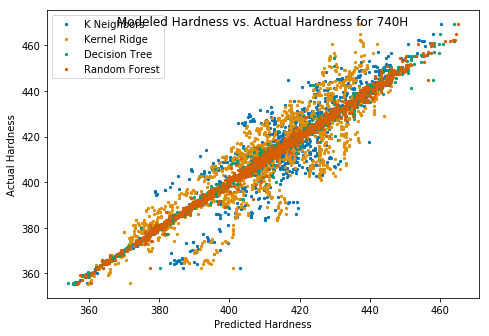

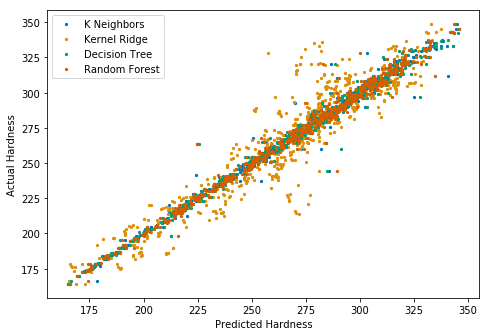

In [42]:
from sklearn.model_selection import KFold, cross_val_score

k_fold=KFold(n_splits=5)

scaler_740 = StandardScaler()
input_data_740 = scaler_740.fit_transform(X)
scaler_347 = StandardScaler()
input_data_347 = scaler_347.fit_transform(Z)
input_train_740, input_test_740, output_train_740, output_test_740 = train_test_split(input_data_740, y, test_size=0.2, random_state=25)
input_train_347, input_test_347, output_train_347, output_test_347 = train_test_split(input_data_347, i, test_size=0.2, random_state=40)

kr_740 = KernelRidge(alpha= 1e-05, gamma= 0.005, kernel= 'rbf')
dt_740 = DecisionTreeRegressor(criterion = 'mae', max_depth = 13)
rf_740 = RandomForestRegressor(criterion = 'mse', max_depth = 15, max_features= 'auto', min_samples_leaf= 4, min_samples_split= 10, n_estimators= 387)
kn_740 = KNeighborsRegressor(n_neighbors= 6, weights= 'uniform')

kr_347 = KernelRidge(alpha= 1e-05, gamma= 0.005, kernel= 'rbf')
dt_347 = DecisionTreeRegressor(criterion = 'mse', max_depth = 13)
rf_347 = RandomForestRegressor(criterion= 'mse',  max_depth = 27.5, max_features= 'auto',min_samples_leaf= 2,min_samples_split= 5, n_estimators= 387)
kn_347 = KNeighborsRegressor(n_neighbors= 2, weights= 'distance')

kn_740.fit(input_train_740, output_train_740)
predicted_test_kn_740 = kn_740.predict(input_test_740)
scores_kn_740 = cross_val_score(kn_740, input_train_740, output_train_740)
print("740H Model K Neighbors Accuracy: %0.2f (+/- %0.2f)" % (scores_kn_740.mean(), scores_kn_740.std() * 2))
kn_347.fit(input_train_347, output_train_347)
predicted_test_kn_347 = kn_347.predict(input_test_347)
scores_kn_347 = cross_val_score(kn_347, input_train_347, output_train_347)
print("347H Model K Neighbors Accuracy: %0.2f (+/- %0.2f)" % (scores_kn_347.mean(), scores_kn_347.std() * 2))

kr_740.fit(input_train_740, output_train_740)
predicted_test_kr_740 = kr_740.predict(input_test_740)
scores_kr_740 = cross_val_score(kr_740, input_train_740, output_train_740)
print("740H Model Kernal Ridge Accuracy: %0.2f (+/- %0.2f)" % (scores_kr_740.mean(), scores_kr_740.std() * 2))
kr_347.fit(input_train_347, output_train_347)
predicted_test_kr_347 = kr_347.predict(input_test_347)
scores_kr_347 = cross_val_score(kr_347, input_train_347, output_train_347)
print("347H Model Kernal Ridge Accuracy: %0.2f (+/- %0.2f)" % (scores_kr_347.mean(), scores_kr_347.std() * 2))

dt_740.fit(input_train_740, output_train_740)
predicted_test_dt_740 = dt_740.predict(input_test_740)
scores_dt_740 = cross_val_score(dt_740, input_train_740, output_train_740)  # cv=k_fold, scoring='precision_macro')
print("740H Model Decision Tree Accuracy: %0.2f (+/- %0.2f)" % (scores_dt_740.mean(), scores_dt_740.std() * 2))
dt_347.fit(input_train_347, output_train_347)
predicted_test_dt_347 = dt_347.predict(input_test_347)
scores_dt_347 = cross_val_score(dt_347, input_train_347, output_train_347)
print("347H Model Decision Tree Accuracy: %0.2f (+/- %0.2f)" % (scores_dt_347.mean(), scores_dt_347.std() * 2))

rf_740.fit(input_train_740, output_train_740)
predicted_test_rf_740 = rf_740.predict(input_test_740)
scores_rf_740 = cross_val_score(rf_740, input_train_740, output_train_740)
print("740H Model Random Forest Accuracy: %0.2f (+/- %0.2f)" % (scores_rf_740.mean(), scores_rf_740.std() * 2))
rf_347.fit(input_train_347, output_train_347)
predicted_test_rf_347 = rf_347.predict(input_test_347)
scores_rf_347 = cross_val_score(rf_347, input_train_347, output_train_347)
print("347H Model Random Forest Accuracy: %0.2f (+/- %0.2f)" % (scores_rf_347.mean(), scores_rf_347.std() * 2))

fig = plt.figure(1)
ax = fig.add_axes([0,0,1,1])
    
fig.suptitle(title)
ax.set_xlabel("Predicted Hardness")
ax.set_ylabel("Actual Hardness")
ax.scatter(predicted_test_kn_740, output_test_740, label='K Neighbors', s=5)
ax.scatter(predicted_test_kr_740, output_test_740, label='Kernel Ridge', s=5)
ax.scatter(predicted_test_dt_740, output_test_740, label='Decision Tree', s=5)
ax.scatter(predicted_test_rf_740, output_test_740, label='Random Forest', s=5)
plt.legend()

fig_2 = plt.figure(2)
ax = fig_2.add_axes([0,0,1,1])
    
fig.suptitle(title)
ax.set_xlabel("Predicted Hardness")
ax.set_ylabel("Actual Hardness")
ax.scatter(predicted_test_kn_347, output_test_347, label='K Neighbors', s=5)
ax.scatter(predicted_test_kr_347, output_test_347, label='Kernel Ridge', s=5)
ax.scatter(predicted_test_dt_347, output_test_347, label='Decision Tree', s=5)
ax.scatter(predicted_test_rf_347, output_test_347, label='Random Forest', s=5)
plt.legend()

# Now Lets Try A Deep Neural Network

In [ ]:
NN_model = Sequential()

#INPUT LAYER
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

#HIDDEN LAYERS
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

#OUTPUT lAYER
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()